# Autodiff

$$f(x) = (x-2)^2$$

In [24]:
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt


<Axes: >

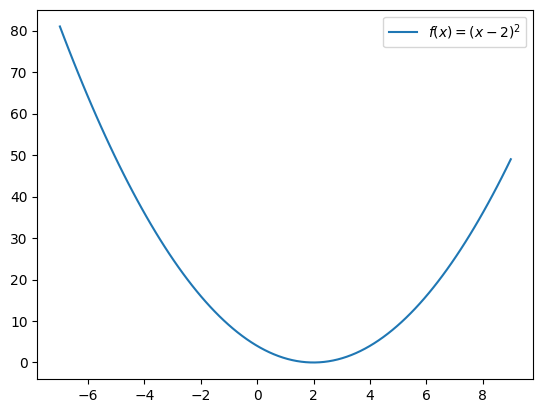

In [3]:
# in pytorch code:
def f(x):
    return torch.pow((x-2.0),2)
x_axis_vals = np.linspace(-7,9,100)
y_axis_vals = f(torch.tensor(x_axis_vals)).numpy()

sns.lineplot(x=x_axis_vals, y= y_axis_vals, label ='$f(x) = (x-2)^2$')
                     

<Axes: >

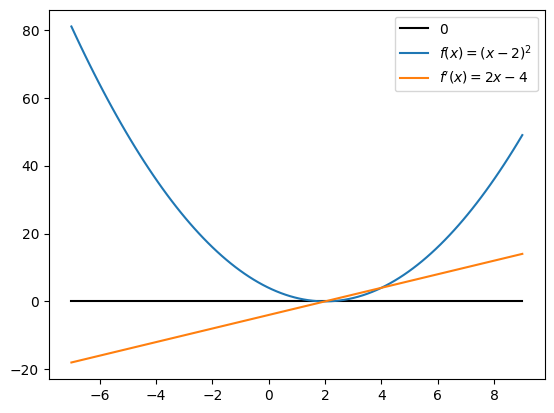

In [4]:
# where is the minimum of this function?
def fP(x): #Defining the derivative of f(x) manually
    return 2*x-4

y_axis_vals_p = fP(torch.tensor(x_axis_vals)).numpy()

#First, lets draw a black line at 0, so that we can easily tell if something is positive or negative
sns.lineplot(x=x_axis_vals, y=[0.0]*len(x_axis_vals), label="0", color='black')
sns.lineplot(x=x_axis_vals, y=y_axis_vals, label='$f(x) = (x-2)^2$')
sns.lineplot(x=x_axis_vals, y=y_axis_vals_p, label="$f'(x)=2 x - 4$")

We can find the exact derivative here, but we will use complicated functions where finding the exact answer is not possible. we use the black line to tell if something is positive or negative. Look at the orange line, when we are too far to the left, we see the derivative is less than 0, the sign of the gradient f' tells us which direction we should move to find a minimizer. The process to minimize a function using the derivative is called gradient descent- we stop when the gradient is close to 0. You can also stop early if you have done a lot of updates, close enough is good enough.
Calculating a derivative with automatic differentiation:
Let's create a new variable to minimize, but add a new flag to tell pytorch to keep track of the gradient:

In [10]:
x = torch.tensor([-3.5], requires_grad=True)
print(x.grad)

None


In [11]:
value = f(x)
print(value)

tensor([30.2500], grad_fn=<PowBackward0>)


pytorch can compute these gradients for us, so we can use pytorch to compute these for us: 

In [16]:
x = torch.tensor([-3.5], requires_grad=True)

x_cur = x.clone()
x_prev = x_cur*100 #Make the initial "previous" solution larger
epsilon = 1e-5
eta = 0.1

while torch.linalg.norm(x_cur-x_prev) > epsilon:
    x_prev = x_cur.clone() #We need to make a clone here so that x_prev and x_cur don't point to the same object
    
    #Compute our function, gradient, and update
    value = f(x)
    value.backward()
    x.data -= eta * x.grad
    x.grad.zero_() #We need to zero out the old gradient, as py-torch will not do that for us
    
    #What are we currently now?
    x_cur = x.data
    
print(x_cur)

tensor([2.0000])


So to use these you don't need to know how backpropagation works, but is inside of autodiff. We just found the minimum of a function, which is called optimization, reduced our loss, and have solved our problem. We take in data, make predictions, then the loss tells us how badly the network is doing, autodiff figures out the gradient for every parameter that controls the network, the parameters are altered in the neural network, and then we make new predictions, look at the loss, autodiff again, rinse and repeat!
A parameter of a model is a value we alter using an optimizer to reduce our loss, Tensors can be converted into parameters.
The Optimizer object, for example an SGD object, stochastic gradient descent- we are minimizing to the lower value of the function, and loop over the optimization problem a fixed number of times, called epochs.

Let's try to train a neural network. We need input data X and output data y. in pytorch we have Dataset objects. Pytorch gives us loaders that handle CPU cores to prefetch data and keep a limited amount in memory at a time!
Let's load MNIST from scikit-learn: we convert from a Numpy Array to a form pytorch likes. The dataset class encodes information about how many items are in the dataset, and how to get to the nth item.

In [17]:
from torch.utils.data import Dataset
from sklearn.datasets import fetch_openml

# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
print(X.shape)

(70000, 784)


In [18]:
class SimpleDataset(Dataset):
        
    def __init__(self, X, y):
        super(SimpleDataset, self).__init__()
        self.X = X
        self.y = y
    
    def __getitem__(self, index):
        #This "work" could have gone in the constructor, but you should get into 
        inputs = torch.tensor(self.X[index,:], dtype=torch.float32)
        targets = torch.tensor(int(self.y[index]), dtype=torch.int64)
        return inputs, targets 

    def __len__(self):
        return self.X.shape[0]
#Now we can make a PyTorch dataset 
dataset = SimpleDataset(X, y)

In [ ]:
from sklearn.datasets import fetch_openml ## this code will not work. why? the code segment below works. why?

# Load MNIST dataset
mnist = fetch_openml("mnist_784", version=1, as_frame=False)
X, y = mnist.data, mnist.target  # X = images, y = labels

# Print dataset length
print("Length: ", len(X))

# Access first example and label
example, label = X[0], y[0]
print("Features shape: ", example.shape)  # 784 features (flattened 28x28 image)
print("Label of index 0: ", label)


The error happens because:

PyTorch datasets return (image, label) tuples, and trying to use dataset[0, :] is invalid.
Pandas does not support multi-dimensional slicing like dataset[0, :].
NumPy slicing works differently.

In [20]:
import torch
from torchvision import datasets, transforms

# Load MNIST dataset
transform = transforms.ToTensor()  # Convert images to PyTorch tensors
dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)

# Print dataset length
print("Length: ", len(dataset))

# ✅ Correct way to get the first image and label
example, label = dataset[0]  # Unpacking (image, label)

print("Features shape: ", example.shape)  # (1, 28, 28) for PyTorch (C, H, W)
print("Label of index 0: ", label)


Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Length:  60000
Features shape:  torch.Size([1, 28, 28])
Label of index 0:  5


In [21]:
print("Length: ", len(dataset))
example, label = dataset[0]
print("Features: ", example.shape) #Will return 784
print("Label of index 0: ", label)

Length:  60000
Features:  torch.Size([1, 28, 28])
Label of index 0:  5


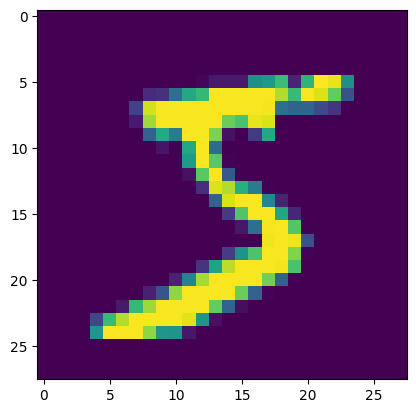

In [25]:
plt.imshow(example.reshape((28,28)))

Let's do our train test split--best practice would be to create two separate Dataset objects, one for training and one for testing. in this case, we have one, and depending on what we are doing- use scikit learn library (will that work here? is this a pandas dataframe? what is this?) can we use torch utils?

In [26]:
train_size = int(len(dataset)*0.8)
test_size = len(dataset)-train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, (train_size, test_size))
print("{} examples for training and {} for testing".format(len(train_dataset), len(test_dataset)))

48000 examples for training and 12000 for testing


In [27]:
# exercise- how can we look at our data?- how many of each label, etc. histograms? Does this code use a random seed?
# can you use torch utils to do any other kind of splits? 